In [3]:

import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
from qiskit.circuit.library import QFT
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction


12


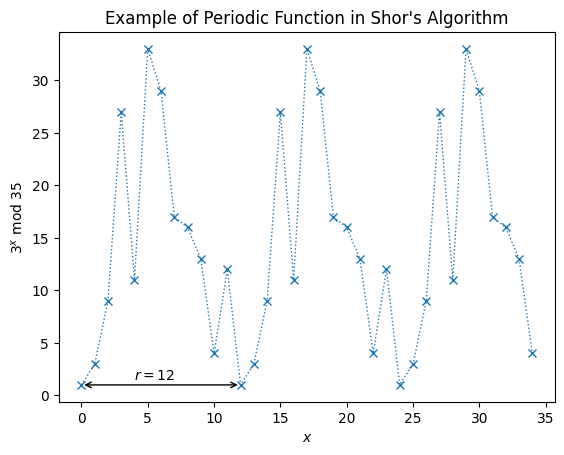

In [4]:
N = 35
a = 3
# Calculate the plotting data
xvals = np.arange(35)

yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

print(yvals[1:].index(1) +1)

In [5]:
# QFT dagger
pi = np.pi
def qft_dagger(n):
    qc = QuantumCircuit(n)
    # for i in range(n//2):
    #     qc.swap(i, n-1-i)
    for j in range(n):
        iterations = range((n-1) - j)
        for k in iterations:
            rotation = 2*pi / 2**(k+2)
            control = k+j+1
            qc.cp(rotation, control, j)
        qc.h(j)
    qc.name = 'QFT+'
    return qc
# n =3
# qc = qft_dagger(n)




In [6]:
def c_amod15(a, power):
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")    
    qc = QuantumCircuit(4)
    for  _ in range(power):
        if a in [2, 13]:
            qc.swap(0,1)
            qc.swap(1,2)
            qc.swap(2,3)
        if a in [7,8]:
            qc.swap(2,3)
            qc.swap(1,2)
            qc.swap(0,1)
        if a in [4,11]:
            qc.swap(1,3)
            qc.swap(0,2)
        if a in [7, 11, 13]:
            qc.x(range(4))
    
    return qc.to_gate(label=f"{a}^{power} mod 15").control()

n = 4
a = 7

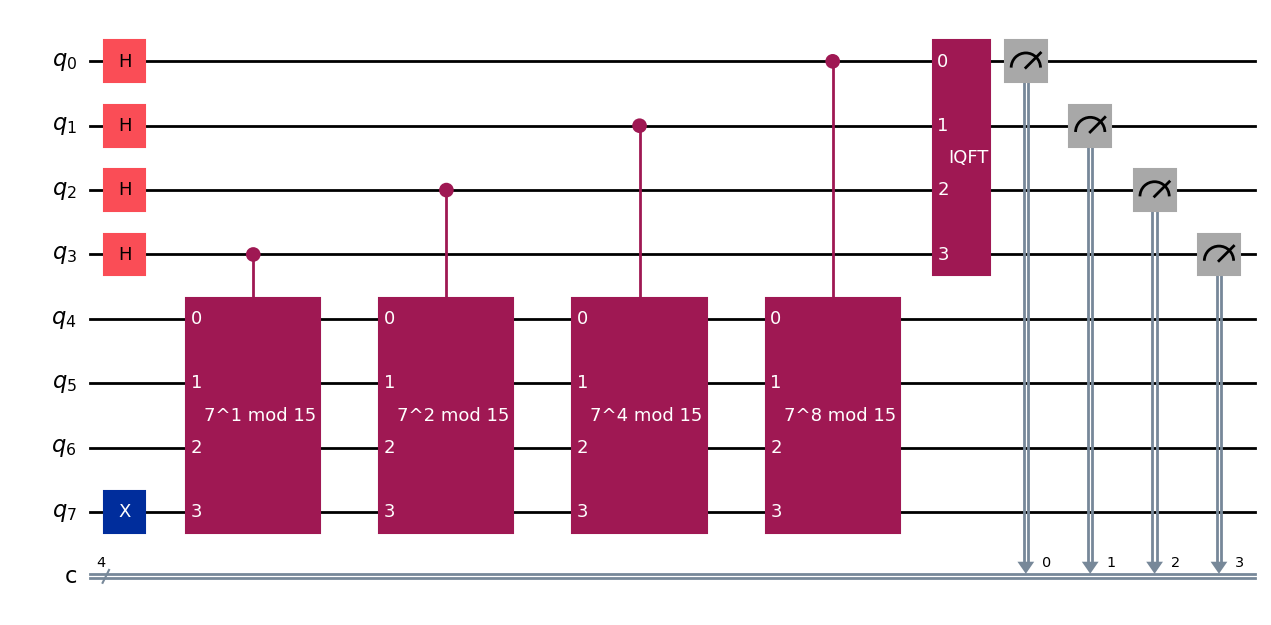

In [7]:
qc = QuantumCircuit(n+4, n)

qc.h(range(n))

qc.x(n+3)
# print(a)
for i in range(n):
    exp = 2**i
    qc.append(c_amod15(a, exp),
               [n-i-1] + [j + n for j in range(4)])

qft_dagger = QFT(n, inverse=True, do_swaps=False).to_gate()
qc.append(qft_dagger, range(n))

qc.measure(range(n), range(n))
qc.draw('mpl')

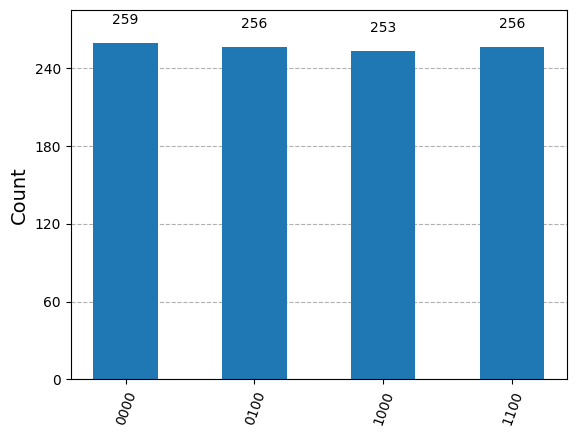

In [17]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)


In [20]:
counts_list = list(counts.keys())
from fractions import Fraction
measured_r = [] 
for output in counts_list:
    decimal = int(output, 2)
    phase = decimal/ (2**n)
    print(decimal, phase)
    frac = Fraction(phase).limit_denominator(15)
    measured_r.append(frac.denominator)

print(measured_r)



12 0.75
0 0.0
8 0.5
4 0.25
[4, 1, 2, 4]
